hid_orderings [0, 0, 0, 0, 0, 0, 0, 0] size 8
num hid layers: 1
expanded_input_ordering [0] size 1
expanded_output_ordering [0, 0] size 2
hid_orderings [2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 2] size 16
num hid layers: 1
expanded_input_ordering [0, 1] size 2
expanded_output_ordering [0, 0, 2, 2] size 4
hid_orderings [0, 6, 4, 1, 5, 5, 2, 5, 1, 4, 3, 5, 2, 2, 5, 3, 4, 4, 4, 6, 3, 4, 2, 0, 5, 1, 5, 6, 4, 1, 2, 2] size 32
num hid layers: 1
expanded_input_ordering [0, 1, 2] size 3
expanded_output_ordering [2, 2, 1, 1, 3, 3] size 6
hid_orderings [2, 14, 17, 10, 5, 2, 19, 0, 10, 7, 16, 22, 28, 19, 30, 29, 19, 7, 14, 5, 30, 13, 23, 1, 4, 5, 7, 10, 8, 13, 13, 3, 1, 11, 2, 13, 0, 16, 2, 21, 12, 30, 8, 14, 23, 10, 10, 19, 30, 27, 12, 22, 21, 11, 7, 2, 27, 1, 16, 16, 4, 20, 28, 24, 12, 3, 30, 16, 19, 24, 11, 1, 4, 20, 10, 27, 22, 30, 20, 9, 24, 0, 16, 27, 15, 4, 15, 16, 11, 27, 10, 8, 15, 6, 9, 12, 29, 2, 6, 6, 30, 27, 6, 17, 2, 9, 10, 16, 28, 25, 16, 24, 15, 22, 24, 7, 25, 17, 15, 12, 6, 1

[Step 540/1000] Immediate Loss: 3.249091358184814 Accumlated Loss: 3.3023037862777707 Duration: 0.3657839298248291
[Step 550/1000] Immediate Loss: 3.3021725273132323 Accumlated Loss: 3.2992365531921384 Duration: 0.3607676029205322
[Step 560/1000] Immediate Loss: 3.2874881362915036 Accumlated Loss: 3.307847092628479 Duration: 0.40618443489074707
[Step 570/1000] Immediate Loss: 3.2956336784362787 Accumlated Loss: 3.313754090309143 Duration: 0.36110687255859375
[Step 580/1000] Immediate Loss: 3.308529033660889 Accumlated Loss: 3.307110284805298 Duration: 0.4040539264678955
[Step 590/1000] Immediate Loss: 3.266728000640869 Accumlated Loss: 3.3071045789718623 Duration: 0.36758947372436523
[Step 600/1000] Immediate Loss: 3.3427077102661134 Accumlated Loss: 3.319442165374756 Duration: 0.3978755474090576
[Step 610/1000] Immediate Loss: 3.277811832427979 Accumlated Loss: 3.3092873697280885 Duration: 0.368602991104126
[Step 620/1000] Immediate Loss: 3.3398999786376953 Accumlated Loss: 3.31377648

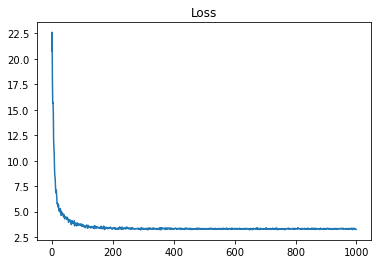

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import time
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal
from gmade import GMADE
random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        
        input_x = torch.cat(x_list, -1)
        
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

class Experiment(nn.Module):
    def __init__(self, USE_CUDA):
        super().__init__()
        
        # guide 1
        
        self.x1_net_1 = simpleNN()
        self.x2_net_1 = simpleNN()
        self.x3_net_1 = simpleNN()
        self.x4_net_1 = simpleNN()
        self.x5_net_1 = simpleNN()
        self.x6_net_1 = simpleNN()
        self.x7_net_1 = simpleNN()
        self.x8_net_1 = simpleNN()
        self.y1_net_1 = simpleNN()
        self.y2_net_1 = simpleNN()
        self.y3_net_1 = simpleNN()
        self.y4_net_1 = simpleNN()
        self.z1_net_1 = simpleNN()
        self.z2_net_1 = simpleNN()
        
        # guide 2
        self.x1_net_2 = simpleNN(2)
        self.x2_net_2 = simpleNN(2)
        self.x3_net_2 = simpleNN(2)
        self.x4_net_2 = simpleNN(2)
        self.x5_net_2 = simpleNN(2)
        self.x6_net_2 = simpleNN(2)
        self.x7_net_2 = simpleNN(2)
        self.x8_net_2 = simpleNN(2)
        self.y1_net_2 = simpleNN(2)
        self.y2_net_2 = simpleNN(2)
        self.y3_net_2 = simpleNN(2)
        self.y4_net_2 = simpleNN(2)
        self.z1_net_2 = simpleNN()
        self.z2_net_2 = simpleNN()
        
        # guide 3
        self.x1_net_3 = simpleNN(7)
        self.x2_net_3 = simpleNN(7)
        self.x3_net_3 = simpleNN(7)
        self.x4_net_3 = simpleNN(7)
        self.x5_net_3 = simpleNN(7)
        self.x6_net_3 = simpleNN(7)
        self.x7_net_3 = simpleNN(7)
        self.x8_net_3 = simpleNN(7)
        self.y1_net_3 = simpleNN(3)
        self.y2_net_3 = simpleNN(3)
        self.y3_net_3 = simpleNN(3)
        self.y4_net_3 = simpleNN(3)
        self.z1_net_3 = simpleNN()
        self.z2_net_3 = simpleNN()

        # guide 4
        self.x1_net_4 = simpleNN(2)
        self.x2_net_4 = simpleNN()
        self.x3_net_4 = simpleNN(2)
        self.x4_net_4 = simpleNN()
        self.x5_net_4 = simpleNN(2)
        self.x6_net_4 = simpleNN()
        self.x7_net_4 = simpleNN(2)
        self.x8_net_4 = simpleNN()
        self.y1_net_4 = simpleNN(2)
        self.y2_net_4 = simpleNN()
        self.y3_net_4 = simpleNN(2)
        self.y4_net_4 = simpleNN()
        self.z1_net_4 = simpleNN(2)
        self.z2_net_4 = simpleNN()
        
        # guide 5
        self.x1_net_5 = simpleNN(14)
        self.x2_net_5 = simpleNN(13)
        self.x3_net_5 = simpleNN(12)
        self.x4_net_5 = simpleNN(11)
        self.x5_net_5 = simpleNN(10)
        self.x6_net_5 = simpleNN(9)
        self.x7_net_5 = simpleNN(8)
        self.x8_net_5 = simpleNN(7)
        self.y1_net_5 = simpleNN(6)
        self.y2_net_5 = simpleNN(5)
        self.y3_net_5 = simpleNN(4)
        self.y4_net_5 = simpleNN(3)
        self.z1_net_5 = simpleNN(2)
        self.z2_net_5 = simpleNN()
        
        # guide 6
        self.x1_net_6 = simpleNN()
        self.x2_net_6 = simpleNN()
        self.x3_net_6 = simpleNN()
        self.x4_net_6 = simpleNN()
        self.x5_net_6 = simpleNN()
        self.x6_net_6 = simpleNN()
        self.x7_net_6 = simpleNN()
        self.x8_net_6 = simpleNN()
        self.y1_net_6 = simpleNN(2)
        self.y2_net_6 = simpleNN(2)
        self.y3_net_6 = simpleNN(2)
        self.y4_net_6 = simpleNN(2)
        self.z1_net_6 = simpleNN(2)
        self.z2_net_6 = simpleNN(2)
        
        # guide 7
        self.x1_net_7 = simpleNN()
        self.x2_net_7 = simpleNN(2)
        self.x3_net_7 = simpleNN()
        self.x4_net_7 = simpleNN(2)
        self.x5_net_7 = simpleNN()
        self.x6_net_7 = simpleNN(2)
        self.x7_net_7 = simpleNN()
        self.x8_net_7 = simpleNN(2)
        self.y1_net_7 = simpleNN(2)
        self.y2_net_7 = simpleNN(3)
        self.y3_net_7 = simpleNN(2)
        self.y4_net_7 = simpleNN(3)
        self.z1_net_7 = simpleNN(2)
        self.z2_net_7 = simpleNN(3)
        
        
        # guide full_made
        input_dim_dict = {
            "r" : 1
        }
        var_dim_dict = {
            "x1" : 1,
            "x2" : 1,
            "x3" : 1,
            "x4" : 1,
            "x5" : 1,
            "x6" : 1,
            "x7" : 1,
            "x8" : 1,
            "y1" : 1,
            "y2" : 1,
            "y3" : 1,
            "y4" : 1,
            "z1" : 1,
            "z2" : 1
        }
        dependency_dict = {
            "z2" : ["r"],
            "z1" : ["r", "z2"],
            "y4" : ["z2"],
            "y3" : ["z2", "y4"],
            "y2" : ["z1"],
            "y1" : ["z1", "y2"],
            "x8" : ["y4"],
            "x7" : ["y4", "x8"],
            "x6" : ["y3"],
            "x5" : ["y3", "x6"],
            "x4" : ["y2"],
            "x3" : ["y2", "x4"],
            "x2" : ["y1"],
            "x1" : ["y1", "x2"]
        }
        to_event_dict = {
            "x1" : 1,
            "x2" : 1,
            "x3" : 1,
            "x4" : 1,
            "x5" : 1,
            "x6" : 1,
            "x7" : 1,
            "x8" : 1,
            "y1" : 1,
            "y2" : 1,
            "y3" : 1,
            "y4" : 1,
            "z1" : 1,
            "z2" : 1
        }
        
        self.full_made = GMADE(input_dim_dict, dependency_dict, var_dim_dict, to_event_dict=to_event_dict)
        if USE_CUDA:
            self.cuda()
    
    # a tree model
    def model(self, obs):
        pyro.module("model", self)
        with pyro.plate("data", obs.shape[0]):
            x1 = pyro.sample("x1", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            x2 = pyro.sample("x2", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            x3 = pyro.sample("x3", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            x4 = pyro.sample("x4", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            x5 = pyro.sample("x5", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            x6 = pyro.sample("x6", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            x7 = pyro.sample("x7", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            x8 = pyro.sample("x8", dist.Normal(torch.zeros(obs.shape[0], 1).cuda(), torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            y1 = pyro.sample("y1", dist.Normal(x1+x2, torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            y2 = pyro.sample("y2", dist.Normal(x3+x4, torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            y3 = pyro.sample("y3", dist.Normal(x5+x6, torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            y4 = pyro.sample("y4", dist.Normal(x7+x8, torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            z1 = pyro.sample("z1", dist.Normal(y1+y2, torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            z2 = pyro.sample("z2", dist.Normal(y3+y4, torch.ones(obs.shape[0], 1).cuda()).to_event(1))
            pyro.sample("obs", dist.Normal(z1+z2, 1.0).to_event(1), obs=obs)
        
    # guide 1 basically inverse the arrows in the model
    def guide_1(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_1([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_1([obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_1([z2])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_1([z2])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_1([z1])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_1([z1])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_1([y4])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_1([y4])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_1([y3])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_1([y3])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_1([y2])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_1([y2])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_1([y1])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_1([y1])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
    
    # guide 2 inverse the arrows in the model and add obs as dependency for each RV 
    def guide_2(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_2([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_2([obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_2([z2, obs])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_2([z2, obs])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_2([z1, obs])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_2([z1, obs])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_2([y4, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_2([y4, obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_2([y3, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_2([y3, obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_2([y2, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_2([y2, obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_2([y1, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_2([y1, obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
    
    # guide 3 inverse the arrows and each RV depends on all RVs in previous levels
    # i.e. x depends on all y + z + obs
    def guide_3(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_3([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_3([obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_3([z1, z2, obs])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_3([z1, z2, obs])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_3([z1, z2, obs])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_3([z1, z2, obs])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_3([y1, y2, y3, y4, z1, z2, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_3([y1, y2, y3, y4, z1, z2, obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_3([y1, y2, y3, y4, z1, z2, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_3([y1, y2, y3, y4, z1, z2, obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_3([y1, y2, y3, y4, z1, z2, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_3([y1, y2, y3, y4, z1, z2, obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_3([y1, y2, y3, y4, z1, z2, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_3([y1, y2, y3, y4, z1, z2, obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
    
    # guide 4 inverse the arrows and each RV depends on its previously sampled sibling (if any) at the same level
    # i.e. x1 depends on y1 and x2, y1 depends on z1 and y2, y3 depends on z2 and y4
    # this should be minimum failthful
    def guide_4(self, obs):
        pyro.module("model", self)
        with pyro.plate("data", obs.shape[0]):
            z2_mean, z2_std = self.z2_net_4([obs])
            z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std).to_event(1))
            z1_mean, z1_std = self.z1_net_4([z2, obs])
            z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std).to_event(1))
            y4_mean, y4_std = self.y4_net_4([z2])
            y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std).to_event(1))
            y3_mean, y3_std = self.y3_net_4([y4, z2])
            y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std).to_event(1))
            y2_mean, y2_std = self.y2_net_4([z1])
            y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std).to_event(1))
            y1_mean, y1_std = self.y1_net_4([y2, z1])
            y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std).to_event(1))
            x8_mean, x8_std = self.x8_net_4([y4])
            x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std).to_event(1))
            x7_mean, x7_std = self.x7_net_4([x8, y4])
            x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std).to_event(1))
            x6_mean, x6_std = self.x6_net_4([y3])
            x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std).to_event(1))
            x5_mean, x5_std = self.x5_net_4([x6, y3])
            x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std).to_event(1))
            x4_mean, x4_std = self.x4_net_4([y2])
            x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std).to_event(1))
            x3_mean, x3_std = self.x3_net_4([x4, y2])
            x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std).to_event(1))
            x2_mean, x2_std = self.x2_net_4([y1])
            x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std).to_event(1))
            x1_mean, x1_std = self.x1_net_4([x2, y1])
            x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std).to_event(1))
    
    # guide 5 inverse the arrows and each RV depends on all previously sampled RV
    # fully-connected
    def guide_5(self, obs):
        pyro.module("model", self)
        z2_mean, z2_std = self.z2_net_5([obs])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
        z1_mean, z1_std = self.z1_net_5([z2, obs])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))
        y4_mean, y4_std = self.y4_net_5([z1, z2, obs])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))
        y3_mean, y3_std = self.y3_net_5([y4, z1, z2, obs])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))
        y2_mean, y2_std = self.y2_net_5([y3, y4, z1, z2, obs])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))
        y1_mean, y1_std = self.y1_net_5([y2, y3, y4, z1, z2, obs])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))
        x8_mean, x8_std = self.x8_net_5([y1, y2, y3, y4, z1, z2, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        x7_mean, x7_std = self.x7_net_5([x8, y1, y2, y3, y4, z1, z2, obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x6_mean, x6_std = self.x6_net_5([x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))
        x5_mean, x5_std = self.x5_net_5([x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x4_mean, x4_std = self.x4_net_5([x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))
        x3_mean, x3_std = self.x3_net_5([x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x2_mean, x2_std = self.x2_net_5([x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x1_mean, x1_std = self.x1_net_5([x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
        
    # guide 6 the order to sample RV is the same as the model but given obs as dependency for xs
    def guide_6(self, obs):
        pyro.module("model", self)

        x1_mean, x1_std = self.x1_net_6([obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
        x2_mean, x2_std = self.x2_net_6([obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x3_mean, x3_std = self.x3_net_6([obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x4_mean, x4_std = self.x4_net_6([obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))        
        x5_mean, x5_std = self.x5_net_6([obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x6_mean, x6_std = self.x6_net_6([obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))        
        x7_mean, x7_std = self.x7_net_6([obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x8_mean, x8_std = self.x8_net_6([obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        y1_mean, y1_std = self.y1_net_6([x1, x2])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))        
        y2_mean, y2_std = self.y2_net_6([x3, x4])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))        
        y3_mean, y3_std = self.y3_net_6([x5, x6])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))        
        y4_mean, y4_std = self.y4_net_6([x7, x8])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))        
        z1_mean, z1_std = self.z1_net_6([y1, y2])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))        
        z2_mean, z2_std = self.z2_net_6([y3, y4])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
    
    # guide 7 is similar to guide 6 but each RV dependent on its subling
    # the inverse of guide 4
    def guide_7(self, obs):
        pyro.module("model", self)
        
        x1_mean, x1_std = self.x1_net_7([obs])
        x1 = pyro.sample("x1", dist.Normal(x1_mean, x1_std))
        x2_mean, x2_std = self.x2_net_7([x1, obs])
        x2 = pyro.sample("x2", dist.Normal(x2_mean, x2_std))
        x3_mean, x3_std = self.x3_net_7([obs])
        x3 = pyro.sample("x3", dist.Normal(x3_mean, x3_std))
        x4_mean, x4_std = self.x4_net_7([x3, obs])
        x4 = pyro.sample("x4", dist.Normal(x4_mean, x4_std))        
        x5_mean, x5_std = self.x5_net_7([obs])
        x5 = pyro.sample("x5", dist.Normal(x5_mean, x5_std))
        x6_mean, x6_std = self.x6_net_7([x5, obs])
        x6 = pyro.sample("x6", dist.Normal(x6_mean, x6_std))        
        x7_mean, x7_std = self.x7_net_7([obs])
        x7 = pyro.sample("x7", dist.Normal(x7_mean, x7_std))
        x8_mean, x8_std = self.x8_net_7([x7, obs])
        x8 = pyro.sample("x8", dist.Normal(x8_mean, x8_std))
        y1_mean, y1_std = self.y1_net_7([x1, x2])
        y1 = pyro.sample("y1", dist.Normal(y1_mean, y1_std))        
        y2_mean, y2_std = self.y2_net_7([x3, x4, y1])
        y2 = pyro.sample("y2", dist.Normal(y2_mean, y2_std))        
        y3_mean, y3_std = self.y3_net_7([x5, x6])
        y3 = pyro.sample("y3", dist.Normal(y3_mean, y3_std))        
        y4_mean, y4_std = self.y4_net_7([x7, x8, y3])
        y4 = pyro.sample("y4", dist.Normal(y4_mean, y4_std))        
        z1_mean, z1_std = self.z1_net_7([y1, y2])
        z1 = pyro.sample("z1", dist.Normal(z1_mean, z1_std))        
        z2_mean, z2_std = self.z2_net_7([y3, y4, z1])
        z2 = pyro.sample("z2", dist.Normal(z2_mean, z2_std))
    
    def guide_full_made(self, obs):
        pyro.module("model", self)
        with pyro.plate("data", obs.shape[0]):
            input_made = {
                    "r" : obs
            }
            output_dict = self.full_made(input_made, suffix="")
        
def generate_data():
    x_len = 8
    xs = torch.randn(x_len)
    ys = []
    i = 0
    while i < len(xs):
        y = dist.Normal(xs[i] + xs[i+1], 2).sample()
        ys.append(y)
        i +=2
        
    zs = []
    i = 0
    while i < len(ys):
        z = dist.Normal(ys[i] + ys[i+1], 1.5).sample()
        zs.append(z)
        i +=2
        
        
    obs = dist.Normal(zs[0] + zs[1], 1).sample()
    return obs
    
USE_CUDA = True
data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data().unsqueeze(0))
data = torch.stack(data)
batches = []
for i in range(5):
    batches.append(data[int(i * num_data / 5): int((i + 1) * num_data / 5)])
experiment = Experiment(USE_CUDA)
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_4 # guide_1

# pyro auto guide
#guide = AutoNormal(experiment.model)
#guide = AutoMultivariateNormal(experiment.model)
#guide = AutoDiagonalNormal(experiment.model)

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())


n_steps = 1000
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    start = time.time()
    for obs in batches:
        if USE_CUDA:
            obs = obs.cuda()
            #print(obs.shape)
        imme_loss += svi.step(obs) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {} Duration: {}".format(step, n_steps, imme_loss, loss, time.time() - start))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

In [2]:
# guide 1
[Step 10/100] Immediate Loss: 5.6792811819911035 Accumlated Loss: 8.161501753419639
[Step 20/100] Immediate Loss: 5.6724499085545546 Accumlated Loss: 5.7964787363111965
[Step 30/100] Immediate Loss: 5.761731808781624 Accumlated Loss: 5.581517954558135
[Step 40/100] Immediate Loss: 6.112146431803706 Accumlated Loss: 5.703019751578569
[Step 50/100] Immediate Loss: 5.990561635196209 Accumlated Loss: 5.61033443725109
[Step 60/100] Immediate Loss: 5.79047949910164 Accumlated Loss: 5.709876654744148
[Step 70/100] Immediate Loss: 5.865784194469453 Accumlated Loss: 5.6813742448389535
[Step 80/100] Immediate Loss: 5.5839250811934455 Accumlated Loss: 5.665409379035234
[Step 90/100] Immediate Loss: 5.802031826376916 Accumlated Loss: 5.689023856550455
[Step 100/100] Immediate Loss: 5.711089228987696 Accumlated Loss: 5.733322246074676

SyntaxError: invalid syntax (<ipython-input-2-54276383af52>, line 2)

In [ ]:
# guide 2
[Step 10/100] Immediate Loss: 6.268227699697018 Accumlated Loss: 9.823156678080556
[Step 20/100] Immediate Loss: 6.012787947654725 Accumlated Loss: 6.139076143831014
[Step 30/100] Immediate Loss: 6.102070910632606 Accumlated Loss: 5.927030056893825
[Step 40/100] Immediate Loss: 6.45776209264994 Accumlated Loss: 5.981230340063572
[Step 50/100] Immediate Loss: 6.256524928808213 Accumlated Loss: 5.893774724751712
[Step 60/100] Immediate Loss: 6.069752818644045 Accumlated Loss: 5.9795956534147265
[Step 70/100] Immediate Loss: 6.092835750877859 Accumlated Loss: 5.928910363674163
[Step 80/100] Immediate Loss: 5.949914609193803 Accumlated Loss: 5.921238815844059
[Step 90/100] Immediate Loss: 6.110138435661791 Accumlated Loss: 5.9243319559395315
[Step 100/100] Immediate Loss: 5.967664820253849 Accumlated Loss: 5.956207058787346

In [ ]:
# guide 3
[Step 10/100] Immediate Loss: 6.570058162808415 Accumlated Loss: 9.397841033637526
[Step 20/100] Immediate Loss: 6.147684178054332 Accumlated Loss: 6.235418024212122
[Step 30/100] Immediate Loss: 6.111919716298578 Accumlated Loss: 5.938203674733639
[Step 40/100] Immediate Loss: 6.531079505085945 Accumlated Loss: 5.937320747315884
[Step 50/100] Immediate Loss: 6.133750829696654 Accumlated Loss: 5.836949352592229
[Step 60/100] Immediate Loss: 5.995875943303109 Accumlated Loss: 5.909800890862941
[Step 70/100] Immediate Loss: 6.01717264592648 Accumlated Loss: 5.870649518340828
[Step 80/100] Immediate Loss: 5.837504681944848 Accumlated Loss: 5.835405748039484
[Step 90/100] Immediate Loss: 6.031392835974693 Accumlated Loss: 5.827427438616752
[Step 100/100] Immediate Loss: 5.949472520351413 Accumlated Loss: 5.865983818709852

In [ ]:
### guide 4 ### best
[Step 10/100] Immediate Loss: 4.377868088781835 Accumlated Loss: 6.545501601159573
[Step 20/100] Immediate Loss: 3.575750644803046 Accumlated Loss: 4.03719574072957
[Step 30/100] Immediate Loss: 3.5968227416276943 Accumlated Loss: 3.657659743905067
[Step 40/100] Immediate Loss: 3.5601295506954207 Accumlated Loss: 3.6178785299956795
[Step 50/100] Immediate Loss: 3.4762910395860662 Accumlated Loss: 3.543176322728395
[Step 60/100] Immediate Loss: 3.52601896584034 Accumlated Loss: 3.533123803049326
[Step 70/100] Immediate Loss: 3.449901377856731 Accumlated Loss: 3.498376666098833
[Step 80/100] Immediate Loss: 3.472165140509606 Accumlated Loss: 3.527985264599323
[Step 90/100] Immediate Loss: 3.535960964262485 Accumlated Loss: 3.4987394436597814
[Step 100/100] Immediate Loss: 3.4975102710723887 Accumlated Loss: 3.5023412067890174

# gpu
[Step 10/1000] Immediate Loss: 9.157310142517089 Accumlated Loss: 15.049692971229552 Duration: 0.35099339485168457
[Step 20/1000] Immediate Loss: 5.85079418182373 Accumlated Loss: 6.951483745574951 Duration: 0.348111629486084
[Step 30/1000] Immediate Loss: 5.0251405143737795 Accumlated Loss: 5.265295015335083 Duration: 0.41347718238830566
[Step 40/1000] Immediate Loss: 4.455887260437011 Accumlated Loss: 4.758720594406128 Duration: 0.35964298248291016
[Step 50/1000] Immediate Loss: 4.326854467391968 Accumlated Loss: 4.419370892524719 Duration: 0.3862590789794922
[Step 60/1000] Immediate Loss: 4.218307285308837 Accumlated Loss: 4.209368563652038 Duration: 0.35480189323425293
[Step 70/1000] Immediate Loss: 3.8374552536010738 Accumlated Loss: 3.978692611694336 Duration: 0.409717321395874
[Step 80/1000] Immediate Loss: 3.751860332489014 Accumlated Loss: 3.820096109390259 Duration: 0.35500216484069824
[Step 90/1000] Immediate Loss: 3.7082661437988285 Accumlated Loss: 3.729127117156982 Duration: 0.39754223823547363
[Step 100/1000] Immediate Loss: 3.5890631103515624 Accumlated Loss: 3.6896474103927615 Duration: 0.3591599464416504
[Step 110/1000] Immediate Loss: 3.474279747009277 Accumlated Loss: 3.586595432281494 Duration: 0.34798717498779297
[Step 120/1000] Immediate Loss: 3.6556751251220705 Accumlated Loss: 3.5458038244247434 Duration: 0.38567328453063965
[Step 130/1000] Immediate Loss: 3.4842983436584474 Accumlated Loss: 3.5041985340118402 Duration: 0.35711145401000977
[Step 140/1000] Immediate Loss: 3.3172739982604984 Accumlated Loss: 3.470182712554932 Duration: 0.39105868339538574
[Step 150/1000] Immediate Loss: 3.4829155921936037 Accumlated Loss: 3.4747222614288327 Duration: 0.3634517192840576
[Step 160/1000] Immediate Loss: 3.342771110534668 Accumlated Loss: 3.420569646835328 Duration: 0.3930521011352539
[Step 170/1000] Immediate Loss: 3.3771132946014406 Accumlated Loss: 3.3877188377380376 Duration: 0.3480498790740967
[Step 180/1000] Immediate Loss: 3.387749195098877 Accumlated Loss: 3.410190097808838 Duration: 0.42006444931030273
[Step 190/1000] Immediate Loss: 3.393511924743653 Accumlated Loss: 3.387726984024048 Duration: 0.35900235176086426
[Step 200/1000] Immediate Loss: 3.293798923492432 Accumlated Loss: 3.370459241867066 Duration: 0.3927791118621826
[Step 210/1000] Immediate Loss: 3.2775422096252442 Accumlated Loss: 3.3615310697555545 Duration: 0.356921911239624
[Step 220/1000] Immediate Loss: 3.3820526409149165 Accumlated Loss: 3.3239399595260624 Duration: 0.3690330982208252
[Step 230/1000] Immediate Loss: 3.253921890258789 Accumlated Loss: 3.351316024780273 Duration: 0.40285444259643555
[Step 240/1000] Immediate Loss: 3.3662335586547854 Accumlated Loss: 3.3590779170989986 Duration: 0.3788950443267822
[Step 250/1000] Immediate Loss: 3.3439441299438477 Accumlated Loss: 3.3786073141098028 Duration: 0.3920586109161377
[Step 260/1000] Immediate Loss: 3.354782133102417 Accumlated Loss: 3.3513808755874637 Duration: 0.35993361473083496
[Step 270/1000] Immediate Loss: 3.3372807884216313 Accumlated Loss: 3.338691305160523 Duration: 0.39347100257873535
[Step 280/1000] Immediate Loss: 3.310175018310547 Accumlated Loss: 3.2986322603225706 Duration: 0.4072144031524658
[Step 290/1000] Immediate Loss: 3.333268260955811 Accumlated Loss: 3.3248736991882324 Duration: 0.41123247146606445
[Step 300/1000] Immediate Loss: 3.3544892120361323 Accumlated Loss: 3.326479442596436 Duration: 0.4039759635925293
[Step 310/1000] Immediate Loss: 3.346428356170654 Accumlated Loss: 3.305378651618958 Duration: 0.42134761810302734
[Step 320/1000] Immediate Loss: 3.403144226074219 Accumlated Loss: 3.311773896217346 Duration: 0.36122655868530273
[Step 330/1000] Immediate Loss: 3.2763449478149416 Accumlated Loss: 3.3266497364044185 Duration: 0.3582150936126709
[Step 340/1000] Immediate Loss: 3.266353530883789 Accumlated Loss: 3.333148896217346 Duration: 0.42594099044799805
[Step 350/1000] Immediate Loss: 3.279413528442383 Accumlated Loss: 3.2995057687759397 Duration: 0.3749394416809082
[Step 360/1000] Immediate Loss: 3.213767147064209 Accumlated Loss: 3.308307558059693 Duration: 0.3870062828063965
[Step 370/1000] Immediate Loss: 3.37831901550293 Accumlated Loss: 3.3509619054794317 Duration: 0.3554391860961914
[Step 380/1000] Immediate Loss: 3.2749361038208002 Accumlated Loss: 3.320907657623291 Duration: 0.43279170989990234
[Step 390/1000] Immediate Loss: 3.2810496330261225 Accumlated Loss: 3.328427023887634 Duration: 0.35605382919311523
[Step 400/1000] Immediate Loss: 3.278467082977295 Accumlated Loss: 3.317427125930786 Duration: 0.38791894912719727
[Step 410/1000] Immediate Loss: 3.3440698432922367 Accumlated Loss: 3.326253881454468 Duration: 0.3630564212799072
[Step 420/1000] Immediate Loss: 3.3230349349975588 Accumlated Loss: 3.3114357585906977 Duration: 0.4106309413909912
[Step 430/1000] Immediate Loss: 3.313874320983887 Accumlated Loss: 3.316153571128845 Duration: 0.39663028717041016
[Step 440/1000] Immediate Loss: 3.3600057220458988 Accumlated Loss: 3.301804824829101 Duration: 0.3836090564727783
[Step 450/1000] Immediate Loss: 3.286161613464355 Accumlated Loss: 3.3144787635803223 Duration: 0.40917134284973145
[Step 460/1000] Immediate Loss: 3.3025293159484863 Accumlated Loss: 3.2997208251953123 Duration: 0.38283514976501465
[Step 470/1000] Immediate Loss: 3.2771983528137203 Accumlated Loss: 3.291448328971863 Duration: 0.4188551902770996
[Step 480/1000] Immediate Loss: 3.287361907958984 Accumlated Loss: 3.3076985902786253 Duration: 0.38308286666870117
[Step 490/1000] Immediate Loss: 3.350705604553223 Accumlated Loss: 3.3191831941604613 Duration: 0.4051980972290039
[Step 500/1000] Immediate Loss: 3.269703922271729 Accumlated Loss: 3.2964485731124875 Duration: 0.36760973930358887
[Step 510/1000] Immediate Loss: 3.309275913238525 Accumlated Loss: 3.3095148010253905 Duration: 0.3980100154876709
[Step 520/1000] Immediate Loss: 3.280012950897217 Accumlated Loss: 3.3023848466873167 Duration: 0.35692524909973145
[Step 530/1000] Immediate Loss: 3.2583084297180176 Accumlated Loss: 3.3132524414062496 Duration: 0.40805792808532715
[Step 540/1000] Immediate Loss: 3.249091358184814 Accumlated Loss: 3.3023037862777707 Duration: 0.3657839298248291
[Step 550/1000] Immediate Loss: 3.3021725273132323 Accumlated Loss: 3.2992365531921384 Duration: 0.3607676029205322
[Step 560/1000] Immediate Loss: 3.2874881362915036 Accumlated Loss: 3.307847092628479 Duration: 0.40618443489074707
[Step 570/1000] Immediate Loss: 3.2956336784362787 Accumlated Loss: 3.313754090309143 Duration: 0.36110687255859375
[Step 580/1000] Immediate Loss: 3.308529033660889 Accumlated Loss: 3.307110284805298 Duration: 0.4040539264678955
[Step 590/1000] Immediate Loss: 3.266728000640869 Accumlated Loss: 3.3071045789718623 Duration: 0.36758947372436523
[Step 600/1000] Immediate Loss: 3.3427077102661134 Accumlated Loss: 3.319442165374756 Duration: 0.3978755474090576
[Step 610/1000] Immediate Loss: 3.277811832427979 Accumlated Loss: 3.3092873697280885 Duration: 0.368602991104126
[Step 620/1000] Immediate Loss: 3.3398999786376953 Accumlated Loss: 3.3137764816284183 Duration: 0.388408899307251
[Step 630/1000] Immediate Loss: 3.3554999160766603 Accumlated Loss: 3.300262495994568 Duration: 0.370255708694458
[Step 640/1000] Immediate Loss: 3.32398515701294 Accumlated Loss: 3.3128390302658084 Duration: 0.40645265579223633
[Step 650/1000] Immediate Loss: 3.3210130500793458 Accumlated Loss: 3.298892056465149 Duration: 0.35892391204833984
[Step 660/1000] Immediate Loss: 3.2175397109985355 Accumlated Loss: 3.2880573740005494 Duration: 0.3479282855987549
[Step 670/1000] Immediate Loss: 3.351421165466309 Accumlated Loss: 3.3231223983764653 Duration: 0.43328332901000977
[Step 680/1000] Immediate Loss: 3.2576738166809083 Accumlated Loss: 3.3032870035171507 Duration: 0.35775184631347656
[Step 690/1000] Immediate Loss: 3.272449645996094 Accumlated Loss: 3.309213233947754 Duration: 0.3954291343688965
[Step 700/1000] Immediate Loss: 3.270857238769531 Accumlated Loss: 3.2929638547897335 Duration: 0.36011576652526855
[Step 710/1000] Immediate Loss: 3.2790110588073733 Accumlated Loss: 3.315713575363159 Duration: 0.42752623558044434
[Step 720/1000] Immediate Loss: 3.299638538360596 Accumlated Loss: 3.3011173324584955 Duration: 0.366910457611084
[Step 730/1000] Immediate Loss: 3.2682429313659664 Accumlated Loss: 3.306383940696717 Duration: 0.39806294441223145
[Step 740/1000] Immediate Loss: 3.2332065010070803 Accumlated Loss: 3.303490586280823 Duration: 0.37712717056274414
[Step 750/1000] Immediate Loss: 3.310677337646484 Accumlated Loss: 3.3010164909362794 Duration: 0.41501855850219727
[Step 760/1000] Immediate Loss: 3.266561450958252 Accumlated Loss: 3.300159492492676 Duration: 0.3900594711303711
[Step 770/1000] Immediate Loss: 3.2882065200805664 Accumlated Loss: 3.2848971471786497 Duration: 0.3660550117492676
[Step 780/1000] Immediate Loss: 3.322351398468018 Accumlated Loss: 3.3257057313919067 Duration: 0.42407703399658203
[Step 790/1000] Immediate Loss: 3.3259357833862304 Accumlated Loss: 3.3010821838378903 Duration: 0.3699007034301758
[Step 800/1000] Immediate Loss: 3.3515318870544433 Accumlated Loss: 3.3092310037612913 Duration: 0.39723944664001465
[Step 810/1000] Immediate Loss: 3.367356910705566 Accumlated Loss: 3.315722069740296 Duration: 0.35505223274230957
[Step 820/1000] Immediate Loss: 3.2537025356292726 Accumlated Loss: 3.301430205345154 Duration: 0.39604759216308594
[Step 830/1000] Immediate Loss: 3.3313663482666014 Accumlated Loss: 3.3168755073547365 Duration: 0.35784435272216797
[Step 840/1000] Immediate Loss: 3.374281883239746 Accumlated Loss: 3.3063914518356325 Duration: 0.40817952156066895
[Step 850/1000] Immediate Loss: 3.2705587673187257 Accumlated Loss: 3.2939389181137084 Duration: 0.35893774032592773
[Step 860/1000] Immediate Loss: 3.2662834167480472 Accumlated Loss: 3.323611269950867 Duration: 0.4060525894165039
[Step 870/1000] Immediate Loss: 3.299567708969116 Accumlated Loss: 3.2936978788375857 Duration: 0.4847078323364258
[Step 880/1000] Immediate Loss: 3.3145069885253906 Accumlated Loss: 3.3072527265548706 Duration: 0.4159691333770752
[Step 890/1000] Immediate Loss: 3.288979301452637 Accumlated Loss: 3.311298152923584 Duration: 0.4421226978302002
[Step 900/1000] Immediate Loss: 3.331672554016113 Accumlated Loss: 3.2962228116989136 Duration: 0.37487053871154785
[Step 910/1000] Immediate Loss: 3.349849491119385 Accumlated Loss: 3.3247341480255126 Duration: 0.40424036979675293
[Step 920/1000] Immediate Loss: 3.3153474044799807 Accumlated Loss: 3.298115752220154 Duration: 0.36104893684387207
[Step 930/1000] Immediate Loss: 3.347795543670654 Accumlated Loss: 3.29688000869751 Duration: 0.405078649520874
[Step 940/1000] Immediate Loss: 3.3006763458251953 Accumlated Loss: 3.3067226610183713 Duration: 0.3592236042022705
[Step 950/1000] Immediate Loss: 3.3473744583129887 Accumlated Loss: 3.31758397769928 Duration: 0.39299511909484863
[Step 960/1000] Immediate Loss: 3.2901748847961425 Accumlated Loss: 3.3202925367355345 Duration: 0.3634631633758545
[Step 970/1000] Immediate Loss: 3.2751164627075195 Accumlated Loss: 3.2988116960525513 Duration: 0.40302443504333496
[Step 980/1000] Immediate Loss: 3.306729278564453 Accumlated Loss: 3.3053677740097047 Duration: 0.3580911159515381
[Step 990/1000] Immediate Loss: 3.3456609630584717 Accumlated Loss: 3.323902424812317 Duration: 0.3670032024383545
[Step 1000/1000] Immediate Loss: 3.2466304969787596 Accumlated Loss: 3.308351089477539 Duration: 0.5125195980072021

In [ ]:
### gmade ###
[Step 10/100] Immediate Loss: 6.091697503328321 Accumlated Loss: 11.86150044506788
[Step 20/100] Immediate Loss: 4.033280954957009 Accumlated Loss: 4.759111630380153
[Step 30/100] Immediate Loss: 3.729229698777201 Accumlated Loss: 3.9092313872575764
[Step 40/100] Immediate Loss: 3.6316562518477444 Accumlated Loss: 3.7232759437263008
[Step 50/100] Immediate Loss: 3.5912016203999513 Accumlated Loss: 3.5814507492780683
[Step 60/100] Immediate Loss: 3.409006274640559 Accumlated Loss: 3.4948545873165124
[Step 70/100] Immediate Loss: 3.545635481178759 Accumlated Loss: 3.461448216050863
[Step 80/100] Immediate Loss: 3.5296939200162885 Accumlated Loss: 3.425615511506796
[Step 90/100] Immediate Loss: 3.399731188714504 Accumlated Loss: 3.419999708920717
[Step 100/100] Immediate Loss: 3.2696896982193002 Accumlated Loss: 3.3859521727561956

# gpu
[Step 10/1000] Immediate Loss: 28.645474891662598 Accumlated Loss: 32.46923538351059 Duration: 0.3118765354156494
[Step 20/1000] Immediate Loss: 20.140543217658998 Accumlated Loss: 24.561776025891305 Duration: 0.2937607765197754
[Step 30/1000] Immediate Loss: 16.37481050491333 Accumlated Loss: 19.07333705496788 Duration: 0.33535194396972656
[Step 40/1000] Immediate Loss: 13.368425827026368 Accumlated Loss: 15.38671475982666 Duration: 0.29599928855895996
[Step 50/1000] Immediate Loss: 11.016235466003419 Accumlated Loss: 12.108031059265137 Duration: 0.3342249393463135
[Step 60/1000] Immediate Loss: 8.497132759094239 Accumlated Loss: 9.264692452430726 Duration: 0.2967672348022461
[Step 70/1000] Immediate Loss: 6.468829097747803 Accumlated Loss: 7.156724786758423 Duration: 0.32948970794677734
[Step 80/1000] Immediate Loss: 5.5583078575134275 Accumlated Loss: 5.902008189201355 Duration: 0.29119873046875
[Step 90/1000] Immediate Loss: 4.963556032180787 Accumlated Loss: 5.233694943428039 Duration: 0.293048620223999
[Step 100/1000] Immediate Loss: 4.868153781890869 Accumlated Loss: 4.961175120353699 Duration: 0.3373074531555176
[Step 110/1000] Immediate Loss: 4.747272834777832 Accumlated Loss: 4.717371043205261 Duration: 0.29387354850769043
[Step 120/1000] Immediate Loss: 4.77202657699585 Accumlated Loss: 4.654214656829835 Duration: 0.32922959327697754
[Step 130/1000] Immediate Loss: 4.455893688201904 Accumlated Loss: 4.513361931800842 Duration: 0.3361806869506836
[Step 140/1000] Immediate Loss: 4.603406753540039 Accumlated Loss: 4.418698398590088 Duration: 0.3919994831085205
[Step 150/1000] Immediate Loss: 4.205460004806518 Accumlated Loss: 4.3214278402328485 Duration: 0.30796360969543457
[Step 160/1000] Immediate Loss: 4.27139030456543 Accumlated Loss: 4.299418837547302 Duration: 0.3729991912841797
[Step 170/1000] Immediate Loss: 4.136210622787476 Accumlated Loss: 4.180789088249207 Duration: 0.3121047019958496
[Step 180/1000] Immediate Loss: 4.182266654968262 Accumlated Loss: 4.158940057754516 Duration: 0.34903693199157715
[Step 190/1000] Immediate Loss: 4.09123836517334 Accumlated Loss: 4.077604190826416 Duration: 0.3060595989227295
[Step 200/1000] Immediate Loss: 3.8515351581573487 Accumlated Loss: 3.9907477827072144 Duration: 0.3020462989807129
[Step 210/1000] Immediate Loss: 3.7652649116516117 Accumlated Loss: 3.938784395217896 Duration: 0.33886003494262695
[Step 220/1000] Immediate Loss: 3.9395818519592285 Accumlated Loss: 3.8765062685012817 Duration: 0.30915260314941406
[Step 230/1000] Immediate Loss: 3.8621268272399902 Accumlated Loss: 3.8862210855484007 Duration: 0.3399207592010498
[Step 240/1000] Immediate Loss: 3.8003242492675784 Accumlated Loss: 3.870174863815307 Duration: 0.29604506492614746
[Step 250/1000] Immediate Loss: 3.6445272636413573 Accumlated Loss: 3.779785706520081 Duration: 0.3441014289855957
[Step 260/1000] Immediate Loss: 3.7637029457092286 Accumlated Loss: 3.727572990417481 Duration: 0.2986483573913574
[Step 270/1000] Immediate Loss: 3.6157450866699223 Accumlated Loss: 3.674282705307007 Duration: 0.33304715156555176
[Step 280/1000] Immediate Loss: 3.5875861167907717 Accumlated Loss: 3.649505294799805 Duration: 0.3106265068054199
[Step 290/1000] Immediate Loss: 3.4999898147583 Accumlated Loss: 3.5941883020401004 Duration: 0.3620624542236328
[Step 300/1000] Immediate Loss: 3.567591018676758 Accumlated Loss: 3.583481592178345 Duration: 0.29308223724365234
[Step 310/1000] Immediate Loss: 3.5853019905090333 Accumlated Loss: 3.5462128639221193 Duration: 0.30051088333129883
[Step 320/1000] Immediate Loss: 3.5454703330993653 Accumlated Loss: 3.5123749027252193 Duration: 0.347367525100708
[Step 330/1000] Immediate Loss: 3.5508033180236818 Accumlated Loss: 3.5439950218200686 Duration: 0.3043985366821289
[Step 340/1000] Immediate Loss: 3.493808183670044 Accumlated Loss: 3.516240322113037 Duration: 0.33291149139404297
[Step 350/1000] Immediate Loss: 3.5204606819152833 Accumlated Loss: 3.4875489130020143 Duration: 0.29442644119262695
[Step 360/1000] Immediate Loss: 3.487391319274902 Accumlated Loss: 3.4969412460327147 Duration: 0.33286619186401367
[Step 370/1000] Immediate Loss: 3.4867223739624023 Accumlated Loss: 3.47367154598236 Duration: 0.2952587604522705
[Step 380/1000] Immediate Loss: 3.404178600311279 Accumlated Loss: 3.4313887786865243 Duration: 0.34160327911376953
[Step 390/1000] Immediate Loss: 3.4566253662109374 Accumlated Loss: 3.4635467624664305 Duration: 0.30103230476379395
[Step 400/1000] Immediate Loss: 3.4031524658203125 Accumlated Loss: 3.4423334703445434 Duration: 0.3343679904937744
[Step 410/1000] Immediate Loss: 3.437589797973633 Accumlated Loss: 3.445955638885498 Duration: 0.2934551239013672
[Step 420/1000] Immediate Loss: 3.4305254745483396 Accumlated Loss: 3.467087458610535 Duration: 0.2950420379638672
[Step 430/1000] Immediate Loss: 3.4124325561523436 Accumlated Loss: 3.3959003705978392 Duration: 0.3310115337371826
[Step 440/1000] Immediate Loss: 3.4083506584167482 Accumlated Loss: 3.393881471633911 Duration: 0.29466772079467773
[Step 450/1000] Immediate Loss: 3.4347219371795656 Accumlated Loss: 3.39964142036438 Duration: 0.3309810161590576
[Step 460/1000] Immediate Loss: 3.3265656852722167 Accumlated Loss: 3.3675982246398926 Duration: 0.296555757522583
[Step 470/1000] Immediate Loss: 3.4610227775573725 Accumlated Loss: 3.400850156784058 Duration: 0.33401060104370117
[Step 480/1000] Immediate Loss: 3.37685188293457 Accumlated Loss: 3.399056836128235 Duration: 0.29609203338623047
[Step 490/1000] Immediate Loss: 3.4419313430786134 Accumlated Loss: 3.3897217569351197 Duration: 0.33090662956237793
[Step 500/1000] Immediate Loss: 3.4230207633972167 Accumlated Loss: 3.4003475246429447 Duration: 0.30504751205444336
[Step 510/1000] Immediate Loss: 3.395289058685303 Accumlated Loss: 3.3760693769454955 Duration: 0.3329806327819824
[Step 520/1000] Immediate Loss: 3.3966053771972655 Accumlated Loss: 3.3817456083297732 Duration: 0.2982442378997803
[Step 530/1000] Immediate Loss: 3.3084476661682127 Accumlated Loss: 3.353052099227906 Duration: 0.2963106632232666
[Step 540/1000] Immediate Loss: 3.4057489967346193 Accumlated Loss: 3.339466228485108 Duration: 0.3337278366088867
[Step 550/1000] Immediate Loss: 3.3545660018920898 Accumlated Loss: 3.377721154212952 Duration: 0.29999327659606934
[Step 560/1000] Immediate Loss: 3.3552959823608397 Accumlated Loss: 3.343118812561035 Duration: 0.33011841773986816
[Step 570/1000] Immediate Loss: 3.3844991874694825 Accumlated Loss: 3.3770285129547117 Duration: 0.30004382133483887
[Step 580/1000] Immediate Loss: 3.429487190246582 Accumlated Loss: 3.349548743247986 Duration: 0.3329911231994629
[Step 590/1000] Immediate Loss: 3.2413233947753906 Accumlated Loss: 3.3280337438583376 Duration: 0.3239881992340088
[Step 600/1000] Immediate Loss: 3.3326664733886715 Accumlated Loss: 3.3676852083206175 Duration: 0.36179113388061523
[Step 610/1000] Immediate Loss: 3.395525283813477 Accumlated Loss: 3.3513045186996466 Duration: 0.31592345237731934
[Step 620/1000] Immediate Loss: 3.268419303894043 Accumlated Loss: 3.3398091859817503 Duration: 0.3591301441192627
[Step 630/1000] Immediate Loss: 3.3351130962371824 Accumlated Loss: 3.3343322324752807 Duration: 0.3169856071472168
[Step 640/1000] Immediate Loss: 3.3750020599365236 Accumlated Loss: 3.3320983238220214 Duration: 0.32368016242980957
[Step 650/1000] Immediate Loss: 3.3008910751342775 Accumlated Loss: 3.3469146718978884 Duration: 0.3561289310455322
[Step 660/1000] Immediate Loss: 3.3249346923828123 Accumlated Loss: 3.3422493209838864 Duration: 0.3186657428741455
[Step 670/1000] Immediate Loss: 3.4729016685485834 Accumlated Loss: 3.3565485239028927 Duration: 0.3653910160064697
[Step 680/1000] Immediate Loss: 3.325834655761719 Accumlated Loss: 3.3186508769989014 Duration: 0.3211078643798828
[Step 690/1000] Immediate Loss: 3.3627269935607913 Accumlated Loss: 3.3128015460968014 Duration: 0.36841797828674316
[Step 700/1000] Immediate Loss: 3.2416428565979007 Accumlated Loss: 3.3147759170532227 Duration: 0.3240361213684082
[Step 710/1000] Immediate Loss: 3.239976062774658 Accumlated Loss: 3.306152648925781 Duration: 0.35913729667663574
[Step 720/1000] Immediate Loss: 3.331307716369629 Accumlated Loss: 3.342268701553345 Duration: 0.3161740303039551
[Step 730/1000] Immediate Loss: 3.3111047172546386 Accumlated Loss: 3.3177096233367918 Duration: 0.3901174068450928
[Step 740/1000] Immediate Loss: 3.361885032653808 Accumlated Loss: 3.3334077072143558 Duration: 0.32385969161987305
[Step 750/1000] Immediate Loss: 3.29816819190979 Accumlated Loss: 3.3066765327453616 Duration: 0.31812286376953125
[Step 760/1000] Immediate Loss: 3.29841796875 Accumlated Loss: 3.310022190093994 Duration: 0.34715795516967773
[Step 770/1000] Immediate Loss: 3.281107082366943 Accumlated Loss: 3.2933409452438354 Duration: 0.33165979385375977
[Step 780/1000] Immediate Loss: 3.3082717132568358 Accumlated Loss: 3.3196176013946532 Duration: 0.35816287994384766
[Step 790/1000] Immediate Loss: 3.3504421806335447 Accumlated Loss: 3.32738166809082 Duration: 0.31704187393188477
[Step 800/1000] Immediate Loss: 3.2881481647491455 Accumlated Loss: 3.308452456474304 Duration: 0.38905787467956543
[Step 810/1000] Immediate Loss: 3.284136838912964 Accumlated Loss: 3.314943544387817 Duration: 0.322110652923584
[Step 820/1000] Immediate Loss: 3.305176105499267 Accumlated Loss: 3.3037649545669554 Duration: 0.3619554042816162
[Step 830/1000] Immediate Loss: 3.393955955505371 Accumlated Loss: 3.3367141866683956 Duration: 0.29704999923706055
[Step 840/1000] Immediate Loss: 3.2559880638122563 Accumlated Loss: 3.30268783569336 Duration: 0.33498573303222656
[Step 850/1000] Immediate Loss: 3.2791462993621825 Accumlated Loss: 3.3085220441818235 Duration: 0.29592418670654297
[Step 860/1000] Immediate Loss: 3.281724548339844 Accumlated Loss: 3.322854890823364 Duration: 0.3008260726928711
[Step 870/1000] Immediate Loss: 3.3175796890258793 Accumlated Loss: 3.301014678001404 Duration: 0.3460514545440674
[Step 880/1000] Immediate Loss: 3.326539611816406 Accumlated Loss: 3.2972715778350827 Duration: 0.2960472106933594
[Step 890/1000] Immediate Loss: 3.2491430473327636 Accumlated Loss: 3.3055799140930175 Duration: 0.33775854110717773
[Step 900/1000] Immediate Loss: 3.3498123550415038 Accumlated Loss: 3.3090501632690428 Duration: 0.31011414527893066
[Step 910/1000] Immediate Loss: 3.3080376243591307 Accumlated Loss: 3.3173300933837893 Duration: 0.33286476135253906
[Step 920/1000] Immediate Loss: 3.3105238723754886 Accumlated Loss: 3.3006394176483154 Duration: 0.2990453243255615
[Step 930/1000] Immediate Loss: 3.348530197143555 Accumlated Loss: 3.3052138490676874 Duration: 0.3319988250732422
[Step 940/1000] Immediate Loss: 3.2989852142333986 Accumlated Loss: 3.3112360324859615 Duration: 0.29785895347595215
[Step 950/1000] Immediate Loss: 3.321433353424072 Accumlated Loss: 3.3080471029281613 Duration: 0.3328404426574707
[Step 960/1000] Immediate Loss: 3.2815662574768067 Accumlated Loss: 3.304311319351197 Duration: 0.29705333709716797
[Step 970/1000] Immediate Loss: 3.318554363250732 Accumlated Loss: 3.295420694351196 Duration: 0.295973539352417
[Step 980/1000] Immediate Loss: 3.3074472808837894 Accumlated Loss: 3.3034933023452764 Duration: 0.32967591285705566
[Step 990/1000] Immediate Loss: 3.2701464557647704 Accumlated Loss: 3.3209096412658683 Duration: 0.2958359718322754
[Step 1000/1000] Immediate Loss: 3.313778133392334 Accumlated Loss: 3.2882585115432743 Duration: 0.3350646495819092

In [ ]:
# guide 5
[Step 10/100] Immediate Loss: 5.436824112832545 Accumlated Loss: 7.459522048622368
[Step 20/100] Immediate Loss: 4.522601895034313 Accumlated Loss: 4.697016129463912
[Step 30/100] Immediate Loss: 4.035572609305381 Accumlated Loss: 4.087585103064775
[Step 40/100] Immediate Loss: 3.9674540817737576 Accumlated Loss: 3.922967136412859
[Step 50/100] Immediate Loss: 3.819277352690697 Accumlated Loss: 3.8670592607259744
[Step 60/100] Immediate Loss: 3.8970872554183003 Accumlated Loss: 3.8228334636390207
[Step 70/100] Immediate Loss: 3.6495595994591716 Accumlated Loss: 3.728844232827424
[Step 80/100] Immediate Loss: 3.6761886674165725 Accumlated Loss: 3.7416907757222653
[Step 90/100] Immediate Loss: 3.6880584159493455 Accumlated Loss: 3.6743881301581856
[Step 100/100] Immediate Loss: 3.7141958668828003 Accumlated Loss: 3.684455200225115

In [ ]:
# guide 6
[Step 10/100] Immediate Loss: 8.01269422084093 Accumlated Loss: 15.49425634944439
[Step 20/100] Immediate Loss: 6.9067663696408275 Accumlated Loss: 7.9501663804352285
[Step 30/100] Immediate Loss: 8.029220328330993 Accumlated Loss: 8.010903750896453
[Step 40/100] Immediate Loss: 8.31351687759161 Accumlated Loss: 8.1114898557961
[Step 50/100] Immediate Loss: 8.786913882493973 Accumlated Loss: 7.755306751757858
[Step 60/100] Immediate Loss: 7.783528136909008 Accumlated Loss: 7.7925652467012405
[Step 70/100] Immediate Loss: 8.006914387047292 Accumlated Loss: 7.681327867358923
[Step 80/100] Immediate Loss: 8.374721429347991 Accumlated Loss: 7.807788733184337
[Step 90/100] Immediate Loss: 7.715019945800301 Accumlated Loss: 7.808754653304815
[Step 100/100] Immediate Loss: 8.256794970929624 Accumlated Loss: 7.728429790437221

In [ ]:
# guide 7
[Step 10/100] Immediate Loss: 7.946083300113675 Accumlated Loss: 15.880016953587534
[Step 20/100] Immediate Loss: 6.707426010072232 Accumlated Loss: 7.429752558678389
[Step 30/100] Immediate Loss: 6.904689866006373 Accumlated Loss: 7.198620594471693
[Step 40/100] Immediate Loss: 7.047841712534428 Accumlated Loss: 7.0875664424300195
[Step 50/100] Immediate Loss: 7.573134193122387 Accumlated Loss: 6.855033908337354
[Step 60/100] Immediate Loss: 7.103918403685091 Accumlated Loss: 6.874631712168455
[Step 70/100] Immediate Loss: 6.944367031455041 Accumlated Loss: 6.938687078088522
[Step 80/100] Immediate Loss: 7.446044615507124 Accumlated Loss: 7.044109266996383
[Step 90/100] Immediate Loss: 6.661473557949067 Accumlated Loss: 6.902258327007294
[Step 100/100] Immediate Loss: 7.03185636729002 Accumlated Loss: 6.8993669908344755
    

In [ ]:
# autoNormal 
[Step 10/100] Immediate Loss: 29.661400873661044 Accumlated Loss: 34.381083221018315
[Step 20/100] Immediate Loss: 21.721210796236996 Accumlated Loss: 24.125531654298307
[Step 30/100] Immediate Loss: 20.717992586493505 Accumlated Loss: 20.629015110522506
[Step 40/100] Immediate Loss: 20.31778262376786 Accumlated Loss: 20.401564517676828
[Step 50/100] Immediate Loss: 21.517062507569797 Accumlated Loss: 20.607605726897724
[Step 60/100] Immediate Loss: 20.558893247246754 Accumlated Loss: 20.390989627033466
[Step 70/100] Immediate Loss: 20.57022605895995 Accumlated Loss: 20.47847183179855
[Step 80/100] Immediate Loss: 19.823867598176 Accumlated Loss: 20.282766120791436
[Step 90/100] Immediate Loss: 20.220103700757026 Accumlated Loss: 20.263966775059696
[Step 100/100] Immediate Loss: 20.07956038057804 Accumlated Loss: 20.539366428911684

In [ ]:
# AutoMultivariateNormal
[Step 10/100] Immediate Loss: 29.280232212543496 Accumlated Loss: 34.96955828201771
[Step 20/100] Immediate Loss: 20.823702557683003 Accumlated Loss: 23.777785731434825
[Step 30/100] Immediate Loss: 17.56564211547375 Accumlated Loss: 18.975887567698955
[Step 40/100] Immediate Loss: 18.09688677370549 Accumlated Loss: 18.158192227423196
[Step 50/100] Immediate Loss: 17.358041861653323 Accumlated Loss: 17.932833659708496
[Step 60/100] Immediate Loss: 17.660284592509267 Accumlated Loss: 17.789189765751363
[Step 70/100] Immediate Loss: 16.889609196186065 Accumlated Loss: 17.35965327256918
[Step 80/100] Immediate Loss: 18.56209426760674 Accumlated Loss: 17.78802405971289
[Step 90/100] Immediate Loss: 17.714577720761305 Accumlated Loss: 17.483879809975623
[Step 100/100] Immediate Loss: 16.55987268984317 Accumlated Loss: 17.230655351817603

In [ ]:
# AutoDiagonalNormal
[Step 10/100] Immediate Loss: 29.594689139127723 Accumlated Loss: 35.09126758885384
[Step 20/100] Immediate Loss: 22.305745403170594 Accumlated Loss: 24.653422838687895
[Step 30/100] Immediate Loss: 19.765058637857443 Accumlated Loss: 20.882928909182546
[Step 40/100] Immediate Loss: 20.646754955649378 Accumlated Loss: 20.50682894957065
[Step 50/100] Immediate Loss: 20.2246539914608 Accumlated Loss: 20.506671326756482
[Step 60/100] Immediate Loss: 21.094068167805677 Accumlated Loss: 20.755982849299905
[Step 70/100] Immediate Loss: 20.336222262978545 Accumlated Loss: 20.427405071496963
[Step 80/100] Immediate Loss: 21.357484986782072 Accumlated Loss: 20.727729279518126
[Step 90/100] Immediate Loss: 21.060880010724066 Accumlated Loss: 20.713297606468206
[Step 100/100] Immediate Loss: 20.076601029038425 Accumlated Loss: 20.360575951337818